In [2]:
import json
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [2]:
more_df = pd.read_csv("/kaggle/input/gpt-wiki-intro/GPT-wiki-intro.csv")

In [3]:
ai_more_df = pd.DataFrame({'text':more_df["generated_text"],'label':1})
human_more_df = pd.DataFrame({'text':more_df["wiki_intro"],'label':0})

In [3]:
# Load the dataset
data = []

with open("/kaggle/input/detection-of-ai-generated-texts/train.jsonl", "r") as file:
    for line in file:
        record = json.loads(line)
        
        # 0=human 1=AI
        data.append({"text": record["abstract"], "label": 0})
        data.append({"text": record["summary"], "label": 0})
        data.append({"text": record["generated"], "label": 1})

data = pd.DataFrame(data)
# data = pd.concat([data, ai_more_df[:4651],human_more_df[:2302]], ignore_index=True)

In [4]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# EDA

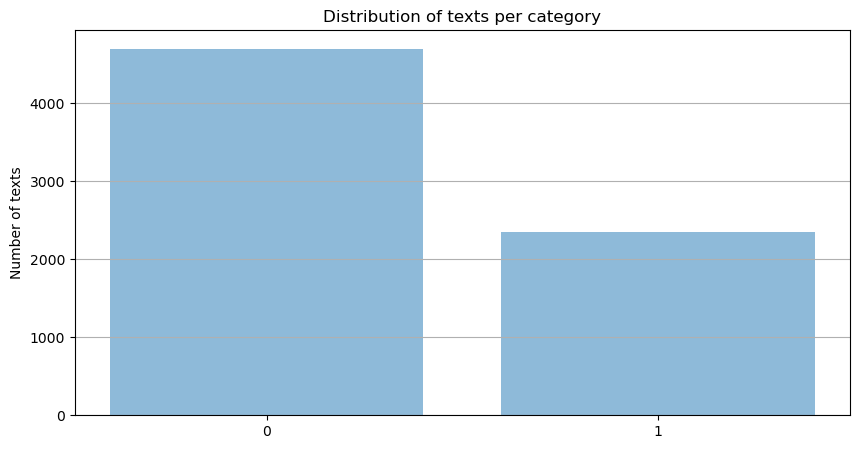

Counter({0: 4698, 1: 2349})


In [5]:
def EDA(data):
    categories = data[['label']].values.reshape(-1)
    counter_categories = Counter(categories)
    category_names = counter_categories.keys()
    category_values = counter_categories.values()

    y_pos = np.arange(len(category_names))

    plt.figure(1, figsize=(10, 5))
    plt.bar(y_pos, category_values, align='center', alpha=0.5)
    plt.xticks(y_pos, category_names)
    plt.ylabel('Number of texts')
    plt.title('Distribution of texts per category')
    plt.gca().yaxis.grid(True)
    plt.show()

    print(counter_categories)
EDA(data)

In [ ]:
EDA(data)

# RobertaTokenizer

In [7]:
# Initialize the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-large")

# Tokenize the data
train_encodings = tokenizer(train_data["text"].tolist(), truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_data["text"].tolist(), truncation=True, padding=True, max_length=256)

# Create TensorFlow datasets

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_data["label"].tolist(),
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_data["label"].tolist(),
))

# Initialize the model and Train

In [9]:
model = TFRobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

# Train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 354310144 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 1051650   
 ficationHead)                                                   
                                                                 
Total params: 355,361,794
Trainable params: 355,361,794
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(train_dataset.batch(8), validation_data=val_dataset.batch(8), epochs=2)

Epoch 1/2
1224/1400 [=========================>....] - ETA: 1:39 - loss: 0.2490 - accuracy: 0.8500

KeyboardInterrupt: 

In [12]:
model.save_weights("more-model-RoB-lg.h5")

# Prediction

In [13]:
# Load the test dataset
test_data = []

with open("/kaggle/input/detection-of-ai-generated-texts/test.jsonl", "r") as file:
    for line in file:
        record = json.loads(line)
        test_data.append({"id": record["id"], "summary1": record["summary1"], "summary2": record["summary2"]})

test_data = pd.DataFrame(test_data)

In [14]:
test_data.head()

,id,summary1,summary2
0,test_0001,The field of few-shot learning has recently se...,We show that rare but catastrophic failures ma...
1,test_0002,Convolutional neural networks (CNNs) have been...,In this paper we propose a hierarchical archit...
2,test_0003,"We propose Episodic Backward Update, a novel d...",One of the distinguishing aspects of human lan...
3,test_0004,A new RL algorithm called Interior Policy Diff...,Distributed computing can significantly reduce...
4,test_0005,We investigate the modularity of deep generati...,We investigate methods for semi-supervised lea...


In [15]:
# Preprocess both summaries
test_data["summary1_encodings"] = test_data["summary1"].apply(lambda x: tokenizer(x, truncation=True, padding=True, max_length=512, return_tensors="tf"))
test_data["summary2_encodings"] = test_data["summary2"].apply(lambda x: tokenizer(x, truncation=True, padding=True, max_length=512, return_tensors="tf"))

In [16]:
# Function to make predictions on a single example
def predict_summary(summary_encoding):
    prediction = model(summary_encoding)
    return np.argmax(prediction.logits, axis=1)[0]

In [17]:
# Make predictions on both summaries
test_data["summary1_pred"] = test_data["summary1_encodings"].apply(predict_summary)
test_data["summary2_pred"] = test_data["summary2_encodings"].apply(predict_summary)

In [18]:
# Compare predictions and assign labels
test_data["label"] = (test_data["summary1_pred"] > test_data["summary2_pred"]).astype(int)

In [19]:
submit = pd.DataFrame({'id':test_data["id"],
                      'answer':test_data["label"]})

submit.to_csv('more-data-submission.csv', index=False)